## Flight Price Prediction
- Key Feature Visualization
- General Trend Identification of the Key Features
- Feature Encoding for further Processing 
- Feature Selection using VIF
- Feature Scaling using Std Scaler
- Linear Modeling 
- Tree/Forest Modeling
- Accuracy Metrics
- Conclusion

In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns, numpy as np

In [2]:
df = pd.read_csv('Flight_Booking.csv')
df = df.drop(columns = ['Unnamed: 0'])

In [3]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


### Numeric Features: Duration, Days Left, Price 
#### Dependent Feature: Price
- Mean and Median Price Values greatly differ: 20900 vs 7500
- Thus, need to consider class of booking (bus vs econ)
#### Days_Left = (flight date - booking date)
- mean: 26 days 
- matches median so few outliers and normal distr.
#### Duration of flight
- mean: 12 hours


In [4]:
#df.isnull().sum()
df.duplicated().sum()

0

No duplicate or null values

([<matplotlib.patches.Wedge at 0x201b8e58f50>,
 [Text(0.27654286173337067, 1.1677003235523737, 'Vistara'),
  Text(-1.113691958782542, -0.44686711776892357, 'Air_India'),
  Text(0.1194160755622762, -1.0934988801536585, 'Indigo'),
  Text(0.7911116107509573, -0.7642921034100942, 'GO_FIRST'),
  Text(1.0305975642945853, -0.384536942919752, 'AirAsia'),
  Text(1.0951112046845128, -0.10359270907952613, 'SpiceJet')],
 [Text(0.16131666934446623, 0.6811585220722178, '42.6%'),
  Text(-0.6496536426231494, -0.2606724853652054, '27.0%'),
  Text(0.065136041215787, -0.5964539346292682, '14.4%'),
  Text(0.43151542404597665, -0.41688660186005133, '7.7%'),
  Text(0.5621441259788645, -0.2097474234107738, '5.4%'),
  Text(0.5973333843733706, -0.05650511404337788, '3.0%')])

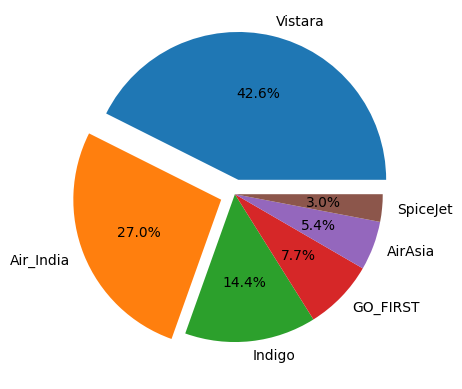

In [5]:
#total flights percentage
s1=(df.airline.value_counts()*100)/(df.airline.value_counts().sum())
plt.pie(x=(df.airline.value_counts()),labels=s1.index,autopct='%1.1f%%',explode=[0.1,0.1,0,0,0,0])

In [6]:
s2=(df.airline.value_counts())
s2

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64

Airline Weights:
1. Vistara
2. AI
3. Indi
4. GO
5. Spice  

In [7]:
econ = df.loc[df['class']=='Economy']
bus = df.loc[df['class']=='Business']
bus.airline.value_counts()

Vistara      60589
Air_India    32898
Name: airline, dtype: int64


Vistara and Air India are the only airlines with business class bookings.
Thus splitting ticket comparisons between Economy and Business help discover further statistical insights

In [8]:
econ.airline.value_counts()

Vistara      67270
Air_India    47994
Indigo       43120
GO_FIRST     23173
AirAsia      16098
SpiceJet      9011
Name: airline, dtype: int64

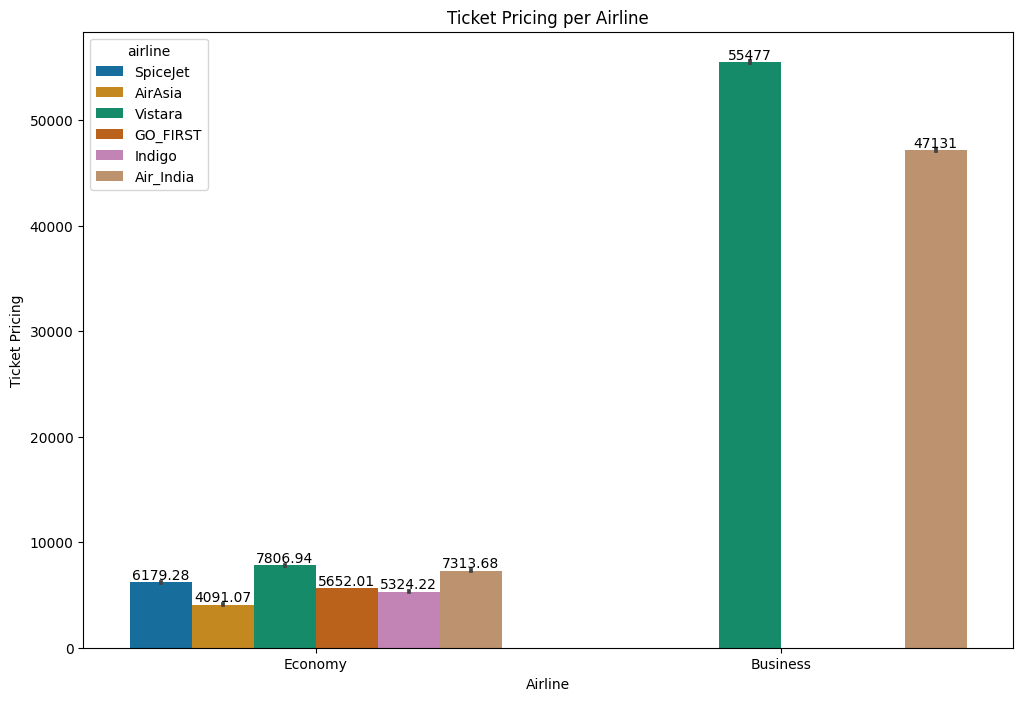

In [9]:
plt.figure(figsize=(12,8))
a = sns.barplot(x=df['class'],y=df['price'],hue=df['airline'],palette='colorblind')
plt.title('Ticket Pricing per Airline')
plt.xlabel('Airline')
plt.ylabel('Ticket Pricing')
for i in a.containers:
    a.bar_label(i,)

- 4000 < Economy prices < 7900 (V>AI>AJ>GF>Ind) 
- Business Prices (V>AI)

Text(0, 0.5, 'Price')

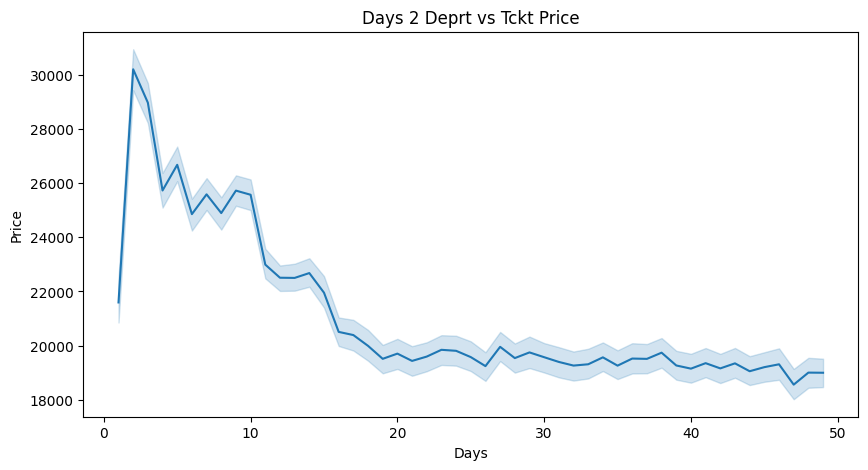

In [10]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x='days_left',y='price')
plt.title('Days 2 Deprt vs Tckt Price')
plt.xlabel('Days')
plt.ylabel('Price')

Prices steadily increase as date of departure nears. 

In [11]:
df['duration'].max()-df['duration'].min()

49.0

Flight Duration does not majorly impact Price

<Axes: title={'center': 'Source'}, xlabel='days_left', ylabel='price'>

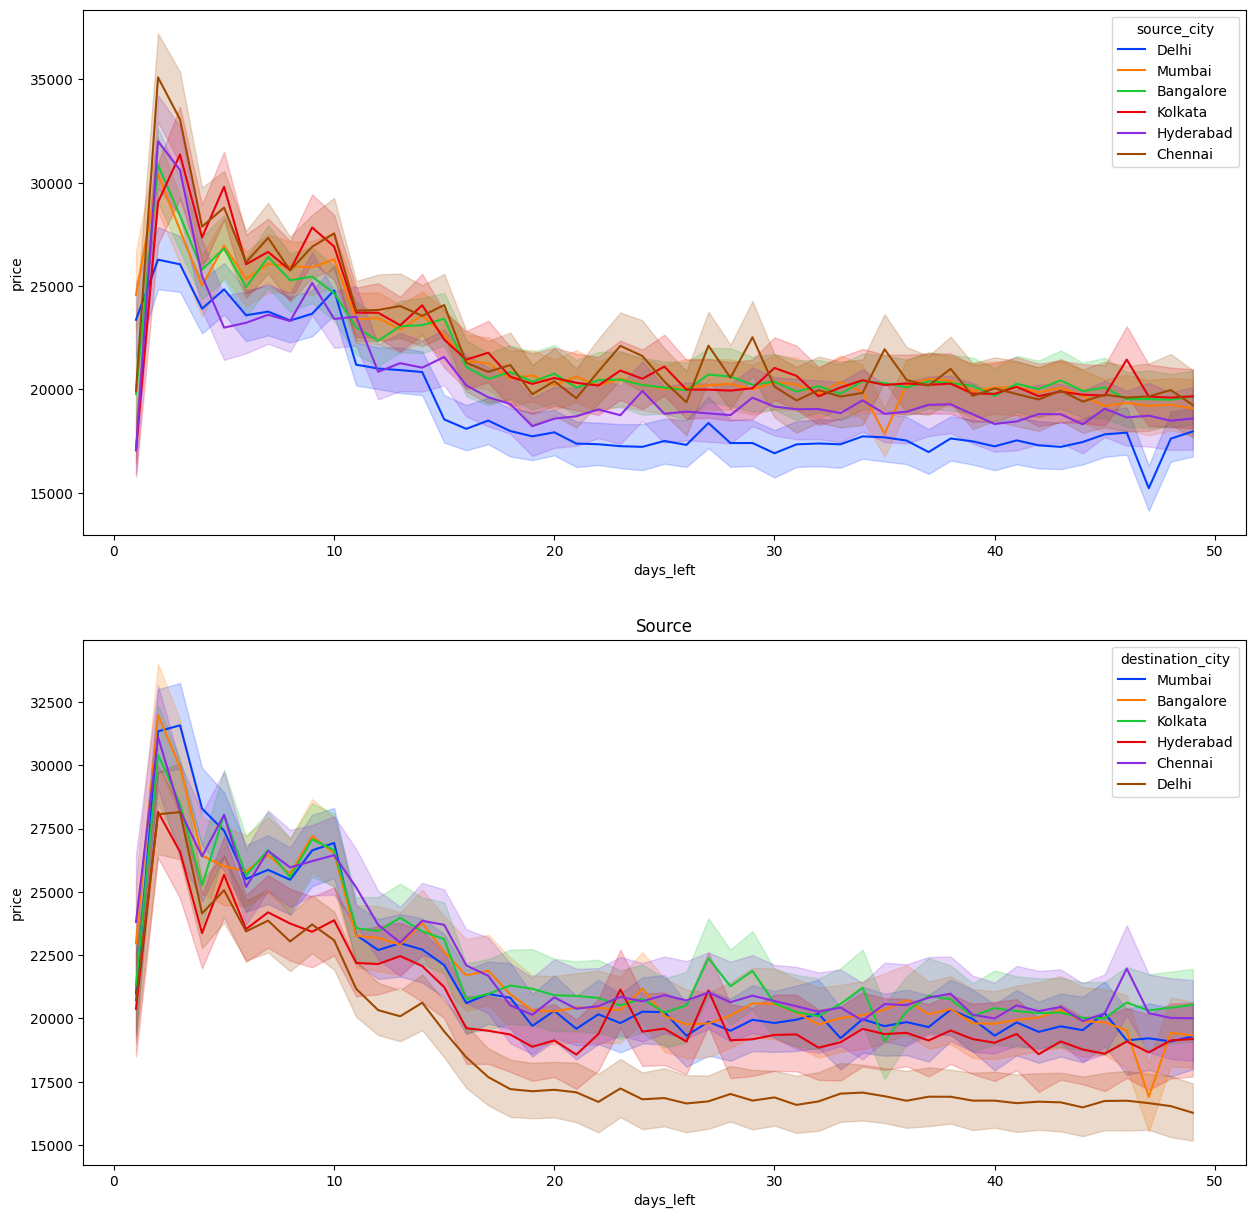

In [12]:
fig,ax=plt.subplots(2,1,figsize=(15,15))
sns.lineplot(x='days_left',y='price',data=df,hue='source_city',ax=ax[0],palette='bright')
plt.title('Source')
sns.lineplot(x='days_left',y='price',data=df,hue='destination_city',ax=ax[1],palette='bright')

Delhi is the cheapest city to travel to and from by a margin.

Text(0.5, 1.0, 'Dest City')

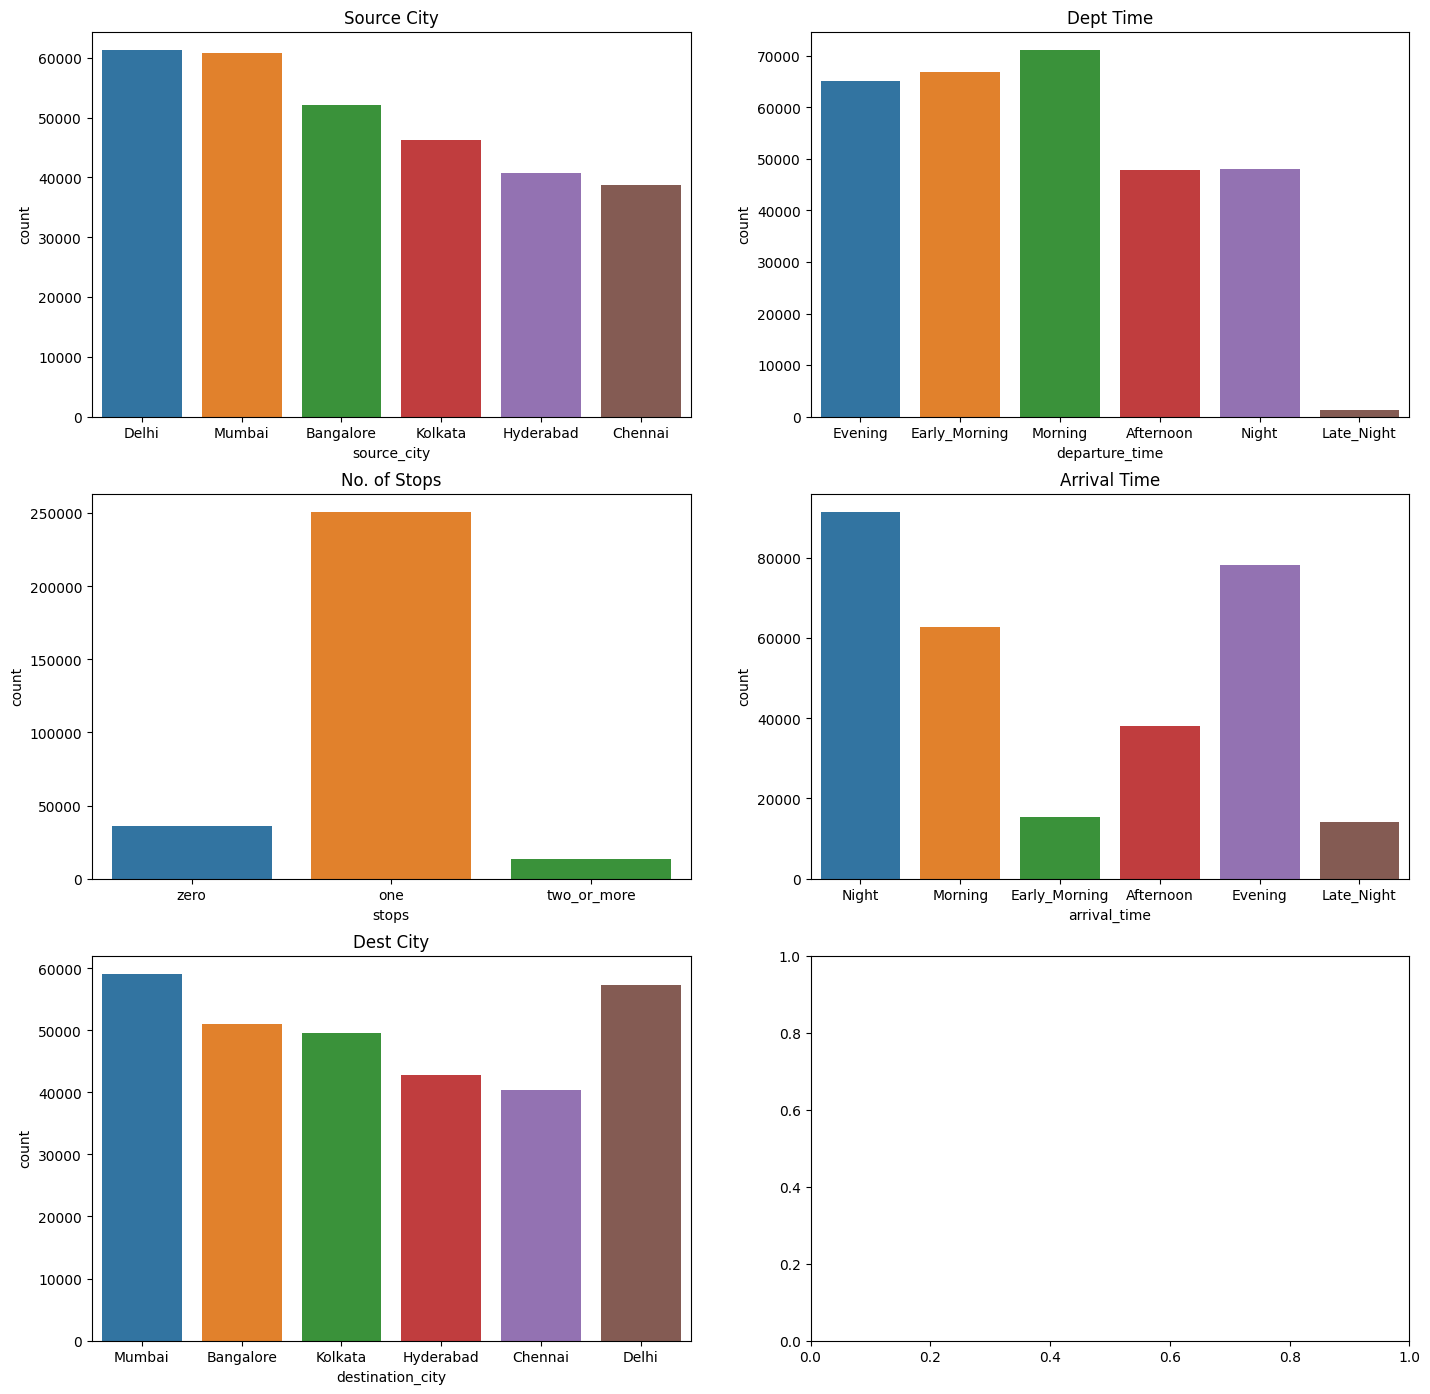

In [13]:
fig,ax = plt.subplots(3,2,figsize=(17,17))
srcity = sns.countplot(df,x='source_city',ax=ax[0,0])
deptt= sns.countplot(df,x='departure_time',ax=ax[0,1])
stps= sns.countplot(df,x='stops',ax=ax[1,0])
arrv= sns.countplot(df,x='arrival_time',ax=ax[1,1])
dest = sns.countplot(df,x='destination_city',ax=ax[2,0])
srcity = sns.countplot(df,x='source_city',ax=ax[0,0])

srcity.set_title("Source City")
deptt.set_title("Dept Time")
stps.set_title("No. of Stops")
arrv.set_title("Arrival Time")
dest.set_title("Dest City")

Most flights:
- depart most often in the evening or morning
- have one stopover.
- arrive at night or in evening, atleast after noon. 

Delhi and Mumbai are the most travelled cities (both as dest. and source).



In [69]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, r2_score,roc_auc_score,mean_absolute_percentage_error,mean_squared_error
import xgboost as xgb
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [15]:
dfo = df.select_dtypes(include=object)

In [16]:
le=LabelEncoder()

In [17]:
#label encoding
dfcorr = df.copy()
for i in dfcorr: 
    dfcorr[i]=le.fit_transform(dfcorr[i])
dfcorr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   airline           300153 non-null  int32
 1   flight            300153 non-null  int32
 2   source_city       300153 non-null  int32
 3   departure_time    300153 non-null  int32
 4   stops             300153 non-null  int32
 5   arrival_time      300153 non-null  int32
 6   destination_city  300153 non-null  int32
 7   class             300153 non-null  int32
 8   duration          300153 non-null  int64
 9   days_left         300153 non-null  int64
 10  price             300153 non-null  int64
dtypes: int32(8), int64(3)
memory usage: 16.0 MB


In [18]:
for i in dfo: 
    dfo[i]=le.fit_transform(dfo[i])
dfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   airline           300153 non-null  int32
 1   flight            300153 non-null  int32
 2   source_city       300153 non-null  int32
 3   departure_time    300153 non-null  int32
 4   stops             300153 non-null  int32
 5   arrival_time      300153 non-null  int32
 6   destination_city  300153 non-null  int32
 7   class             300153 non-null  int32
dtypes: int32(8)
memory usage: 9.2 MB


<Axes: >

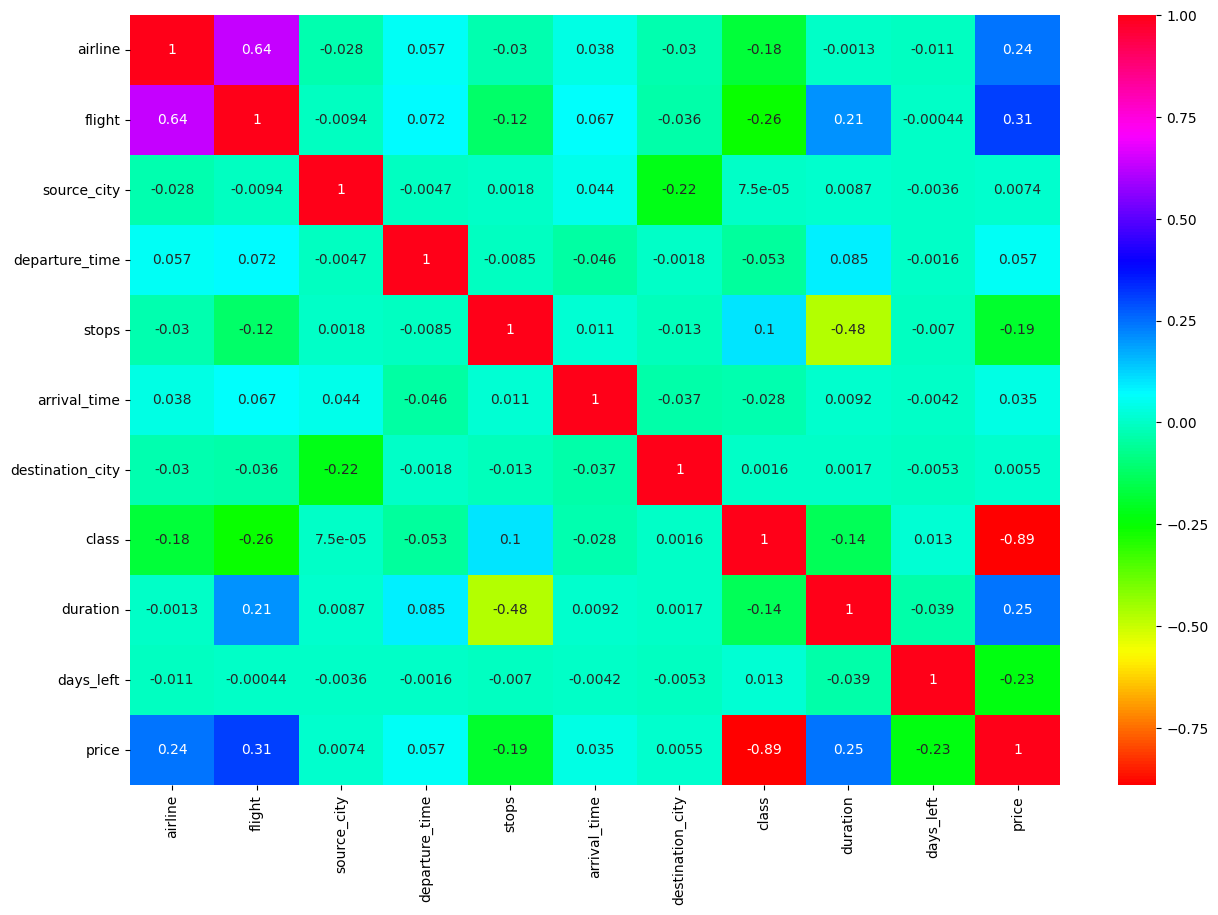

In [20]:
#feature selection
plt.figure(figsize=(15,10))
sns.heatmap(dfcorr.corr(),annot=True,cmap='hsv')

In [21]:
vart = VarianceThreshold(threshold=0)
vart.fit(dfcorr)
vart.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [38]:
col=[]
for c in dfcorr.columns:
    if c!='price':
        col.append(c)
col

['airline',
 'source_city',
 'departure_time',
 'stops',
 'arrival_time',
 'destination_city',
 'class',
 'duration',
 'days_left']

In [39]:
X=dfcorr[col]
vifdf = pd.DataFrame()
vifdf['feature']=X.columns
vifdf['VIF']=[variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
print(vifdf)
#drop flight

            feature       VIF
0           airline  3.376737
1       source_city  2.914358
2    departure_time  2.771473
3             stops  1.436293
4      arrival_time  3.669504
5  destination_city  2.870019
6             class  2.838291
7          duration  3.812975
8         days_left  3.772279


In [36]:
dfcorr=dfcorr.drop(columns=['flight'])

In [45]:
#feature scaling
X=dfcorr.drop(columns=['price'])
y=df['price']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=56)
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [64]:
#linear model
lr=LinearRegression()
lr.fit(X_train,y_train)
ypred=lr.predict(X_test)

In [52]:
diff=pd.DataFrame(np.c_[y_test,ypred],columns=['Actual','Predicted'])
diff

,Actual,Predicted
0,38926.0,51768.717993
1,51707.0,53897.623379
2,79369.0,57406.961499
3,12747.0,11069.300996
4,6578.0,9580.206631
...,...,...
60026,5892.0,9357.686150
60027,8264.0,6618.245305
60028,2343.0,-3284.531621
60029,4209.0,6348.932510


In [60]:
#metrics
r2=r2_score(y_test,ypred)
map=mean_absolute_percentage_error(y_test,ypred)
mse=mean_squared_error(y_test,ypred)
msre=np.sqrt(mse)
print('r2:',r2,'map:',map,'mse:',mse,'msre:',msre)

r2: 0.9044738707797335 map: 0.4388009769194954 mse: 49416260.072872415 msre: 7029.669983212044


C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,label="Actual")
C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ypred,label="Predicted")


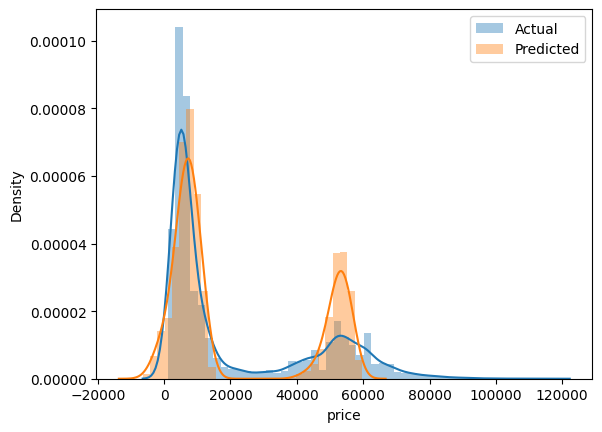

In [63]:
sns.distplot(y_test,label="Actual")
sns.distplot(ypred,label="Predicted")
plt.legend()

In [66]:
#tree model
dt=DecisionTreeRegressor()
dt.fit(X_train,y_train)
ypred=dt.predict(X_test)

In [67]:
#metrics
r2=r2_score(y_test,ypred)
map=mean_absolute_percentage_error(y_test,ypred)
mse=mean_squared_error(y_test,ypred)
msre=np.sqrt(mse)
print('r2:',r2,'map:',map,'mse:',mse,'msre:',msre)

r2: 0.9774300072151434 map: 0.07388390602737507 mse: 11675597.476870283 msre: 3416.957341974038


C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,label="Actual")
C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ypred,label="Predicted")


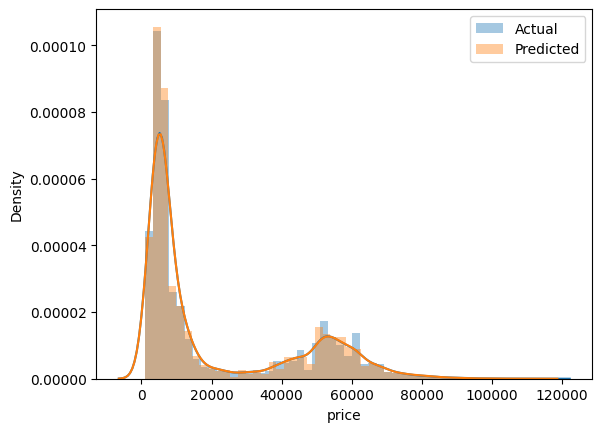

In [68]:
sns.distplot(y_test,label="Actual")
sns.distplot(ypred,label="Predicted")
plt.legend()

In [70]:
#forest model
fr=RandomForestRegressor()
fr.fit(X_train,y_train)
ypred=fr.predict(X_test)

In [71]:
#metrics
r2=r2_score(y_test,ypred)
map=mean_absolute_percentage_error(y_test,ypred)
mse=mean_squared_error(y_test,ypred)
msre=np.sqrt(mse)
print('r2:',r2,'map:',map,'mse:',mse,'msre:',msre)

r2: 0.9853964865108538 map: 0.07092884686206578 mse: 7554488.247852572 msre: 2748.542931782688


C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test,label="Actual")
C:\Users\kandp\AppData\Local\Temp\ipykernel_23164\2117651488.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ypred,label="Predicted")


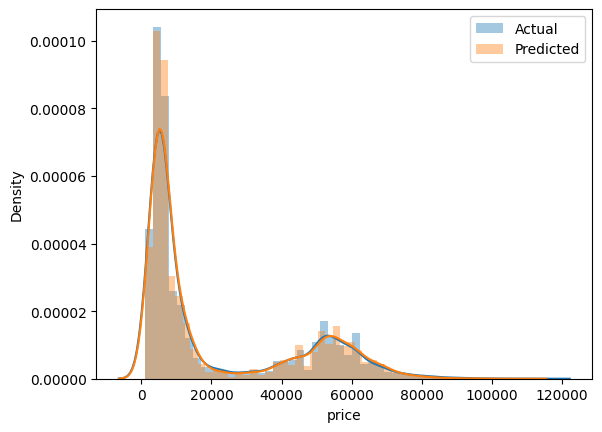

In [72]:
sns.distplot(y_test,label="Actual")
sns.distplot(ypred,label="Predicted")
plt.legend()

## Conclusion:

#### Clearly Linear model struggles to predict business class ticket prices accurately which affects the models efficacy. 
#### Using Trees/Forest Regressor we can accurately predict the price of a flight ticket.

